In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
from junctionart.roundabout.encodingGFN.gflownet.gflownet import GFlowNet
from junctionart.roundabout.encodingGFN.policy import ForwardPolicy, BackwardPolicy
from junctionart.roundabout.encodingGFN.setGenerationEnv import SetGenerationEnv
from junctionart.roundabout.encodingGFN.gflownet.utils import trajectory_balance_loss
from torch.optim import Adam
from tqdm import tqdm
import torch 

size = 5
nActions = 30
losses = []
rewards = []

flows = []
threePoints = [
            {"x": 80, "y": 20, "heading": math.radians(30),'leftLane': 1, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None},
            {"x": 210, "y": 20, "heading": math.radians(145),'leftLane': 1, 'rightLane': 2, 'medianType': None, 'skipEndpoint': None},
            # {"x": 120, "y": 110, "heading": math.radians(280),'leftLane': 2, 'rightLane': 1, 'medianType': None, 'skipEndpoint': None},
        ]


# threePoints should not really be a part of setEnv. TO-DO: fix that later
setEnv = SetGenerationEnv(size, nActions, threePoints)

def train(batch_size, num_epochs):
    forward_policy = ForwardPolicy(setEnv.state_dim, hidden_dim=128, num_actions=setEnv.num_actions)
    backward_policy = BackwardPolicy(setEnv.state_dim, num_actions=setEnv.num_actions)
    
    model = GFlowNet(forward_policy, backward_policy, setEnv)

    opt = Adam([
        {"params": model.forward_policy.parameters()},
        {"params": model.total_flow, "lr": 5e-2},
    ],
    lr=5e-5)
    
    for i in (p := tqdm(range(num_epochs))):
        s0 = torch.zeros(batch_size, size).float()
   
        s, log, traj_length = model.sample_states(s0, return_log=True)

        loss = trajectory_balance_loss(log.total_flow,
                                       log.rewards,
                                       log.fwd_probs,
                                       log.back_probs)

        
        flows.append(model.total_flow.item())
        rewards.append(log.rewards.mean())
        losses.append(loss.item())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-2)
        opt.step()
        opt.zero_grad()
        if i % 10 == 0: p.set_description(f"{loss.item():.3f} T.L : {traj_length}")

    return model, losses, rewards, flows

batch_size = 128
num_epochs = 1000

model, losses, rewards, flows = train(batch_size, num_epochs)

0.011 T.L : 6: 100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [01:18<00:00, 12.71it/s]


Text(0.5, 0.98, 'Size = 5, Action = 30, Num_epchs = 1000, Bcz_size = 128')

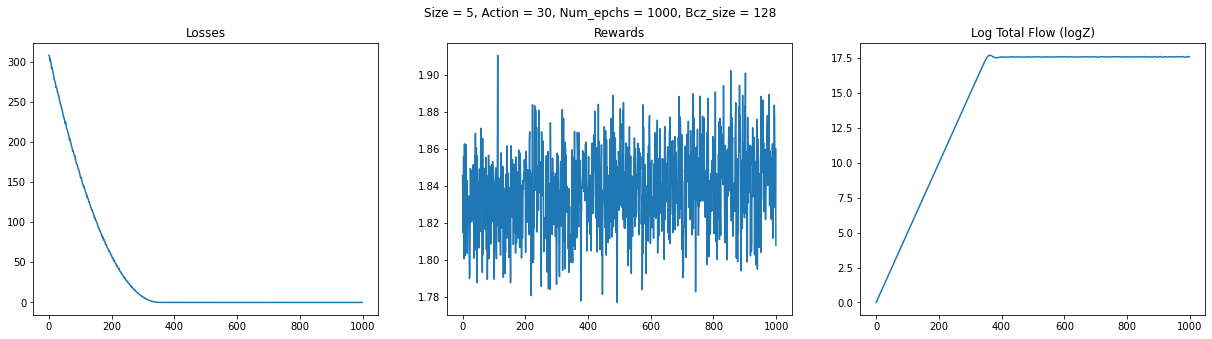

In [3]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(1, 3, figsize=(21, 5))
ax[0].plot(losses)
ax[0].set_title("Losses")
ax[1].plot(rewards)
ax[1].set_title("Rewards")
ax[2].plot(flows)
ax[2].set_title("Log Total Flow (logZ)")


plt.suptitle(f"Size = {size}, Action = {nActions}, Num_epchs = {num_epochs}, Bcz_size = {batch_size}")

In [3]:
trainedDict = setEnv.encodingToReward.copy()

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.64it/s]


torch.Size([100000, 5])
tensor([[18., 26., 18., 28., 27.],
        [15., 24., 30., 14.,  3.],
        [25.,  9., 29., 11.,  2.],
        [ 1., 12., 15., 23., 12.],
        [ 3., 11.,  5., 22.,  6.]])


100%|███████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:00<00:00, 685171.38it/s]


Text(0.5, 0.98, 'Size = 5, Action = 30, Total Samples = 100000')

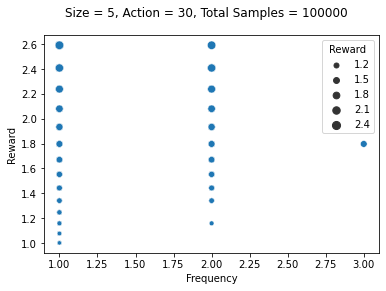

In [4]:
nIter = 1
nBatch = 10**5
terminalStates = []
for i in tqdm(range(nIter)):
    s0 = torch.zeros(nBatch, size).float()
    s, traj_length = model.sample_states(s0, return_log=False)
    terminalStates.append(s)
    
s = torch.concat(terminalStates)
print(s.shape)
print(s[:5])
import seaborn as sns
import pandas as pd


statesForPlot = setEnv.getStateForm(s).long().tolist()
rewardsForPlot = setEnv.reward(s, showProgress=True).tolist()

cnts = []
cnt = 0

stateDict = {}
for i in tqdm(range(len(statesForPlot))):
    state = str(statesForPlot[i])
    if state in stateDict:
        reward, freq = stateDict[state]
        stateDict[state] = (reward, freq + 1)
    else:
        stateDict[state] = (rewardsForPlot[i], 1)
        if rewardsForPlot[i] >= 3**0.85:
            cnt += 1
    cnts.append(cnt)        
    

allRewards = []
freqs = []
for _ in stateDict:
    reward, freq = stateDict[_]
    allRewards.append(reward)
    freqs.append(freq)

# plt.xlim(0, 150)

sns.scatterplot(data=pd.DataFrame({'Frequency':freqs, 'Reward':allRewards}), x='Frequency', y='Reward', size='Reward')
plt.suptitle(f"Size = {size}, Action = {nActions}, Total Samples = {nIter * nBatch}")
# plt.savefig("figs/distribution30.png")

# Exp = 3 

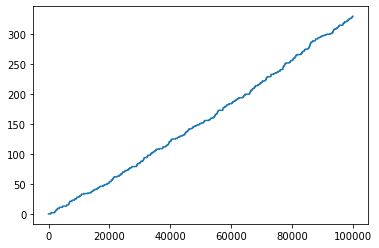

In [5]:
plt.plot(cnts)
import pickle
with open('ablationPickle/exp3.pkl', 'wb') as file:
    pickle.dump(cnts, file)

# Exp = 10 

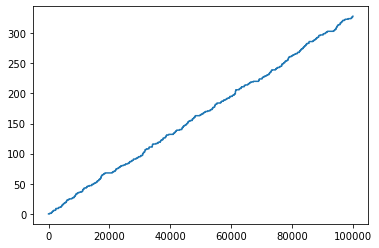

In [6]:
plt.plot(cnts)
import pickle
with open('ablationPickle/exp10.pkl', 'wb') as file:
    pickle.dump(cnts, file)

# Exp = 100 

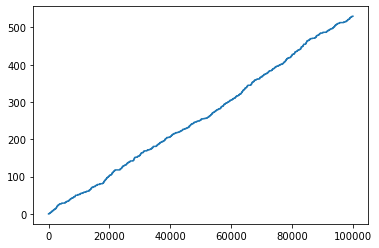

In [5]:
plt.plot(cnts)
import pickle
with open('ablationPickle/exp100.pkl', 'wb') as file:
    pickle.dump(cnts, file)

# Exp = 1000

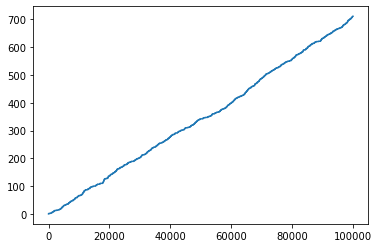

In [8]:
plt.plot(cnts)
import pickle
with open('ablationPickle/exp1000.pkl', 'wb') as file:
    pickle.dump(cnts, file)

# Exp = 10000

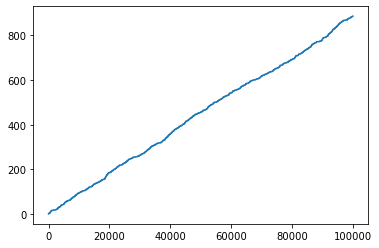

In [5]:
plt.plot(cnts)
import pickle
with open('ablationPickle/exp10000.pkl', 'wb') as file:
    pickle.dump(cnts, file)

In [31]:
import seaborn as sns
import numpy as np
cnts = {"No of Modes Found" : [], "Iteration" : [], "Base" : []}
for b in [3, 10, 100, 1000, 10000]:
    with open(f'ablationPickle/exp{b}.pkl', 'rb') as file:
      
        # Call load method to deserialze
        cnt = pickle.load(file)
        for i, val in enumerate(cnt):
            cnts["No of Modes Found"].append(val)
            cnts["Iteration"].append(i + 1)
            cnts["Base"].append(b)

df = pd.DataFrame(cnts)

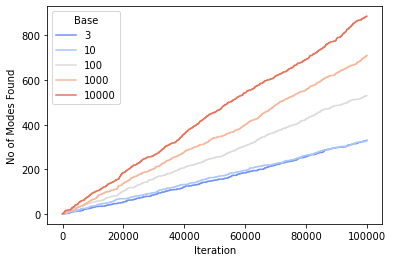

In [33]:
# sns.set_palette("tab10")
import matplotlib.pyplot as plt
sns.lineplot(data=df, x="Iteration", y="No of Modes Found", hue="Base", palette=sns.color_palette('coolwarm', n_colors=5))
plt.savefig("figs/ablationBase.png", dpi = 300)